In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA, NMF, MiniBatchNMF
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 490
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(490, IMG_SIZE)

In [2]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


This is the image used in ['Vision Transformers Need Registers'](https://arxiv.org/abs/2309.16588) for attention visualization, so I've reused it here. I couldn't find the original source so have just cropped from the paper.

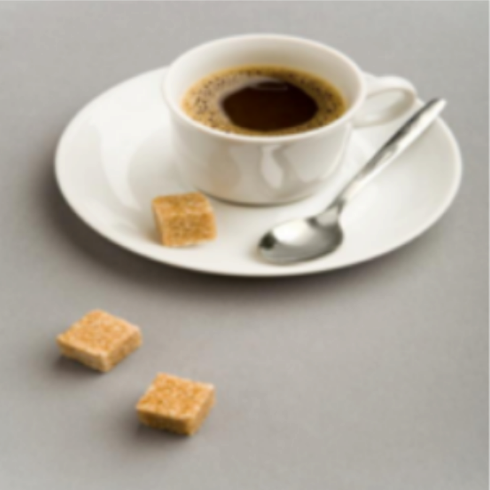

In [3]:
tensor, img = tr.load_image("data/coffee.png", transform)
tensor.to(torch.float16)
tensor = tensor.cuda()
img

We run the high-res model at stride 4 with 1, 2 pixel shifts and save the attention maps of the CLS token. The CLS token is a global descriptor of the image (used later in downstream tasks like classification). The attention map is the values at each of the N attention heads of the last layer of the network for the CLS token with every spatial token.

In [4]:
shift_dists = [i for i in range(1, 3)]
transforms, inv_transforms = tr.get_shift_transforms(shift_dists, 'Moore')
net.set_transforms(transforms, inv_transforms)
# run sequentially or we get OOM in attention calculation
cls_attn, _ = net.forward_sequential(tensor, attn="cls")
cls_attn = tr.to_numpy(cls_attn)

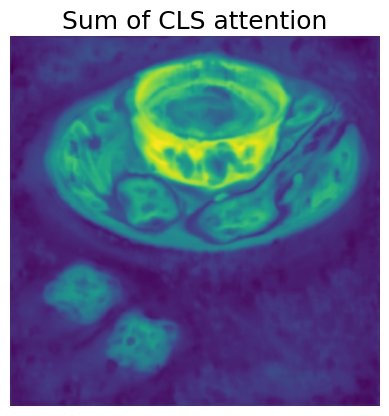

In [5]:
plt.imshow(np.sum(cls_attn, axis=0))
plt.title("Sum of CLS attention", fontsize=18)
plt.gca().set_axis_off()

In the paper, they found self-supervised ViTs were using irrelevant (i.e background) feature tokens to store information causing artefacts in the features and attention. They fixed this by including ~4 register tokens that are discarded at the end of the forward pass but exist for the network to store information during the forward pass. They showed this fixed the artefacting, and also showed they appeared to contain information about distinct objects in the image. We plot these attention maps of the register tokens here in high-resolution. We see similar reuslts to theirs, and see decomposition of the image into objects like sugar cubes, spoon, coffee, the mug *etc.*

In [6]:
attn, _ = net.forward_sequential(tensor, attn="reg")
attn = tr.to_numpy(attn)

(24, 490, 490)


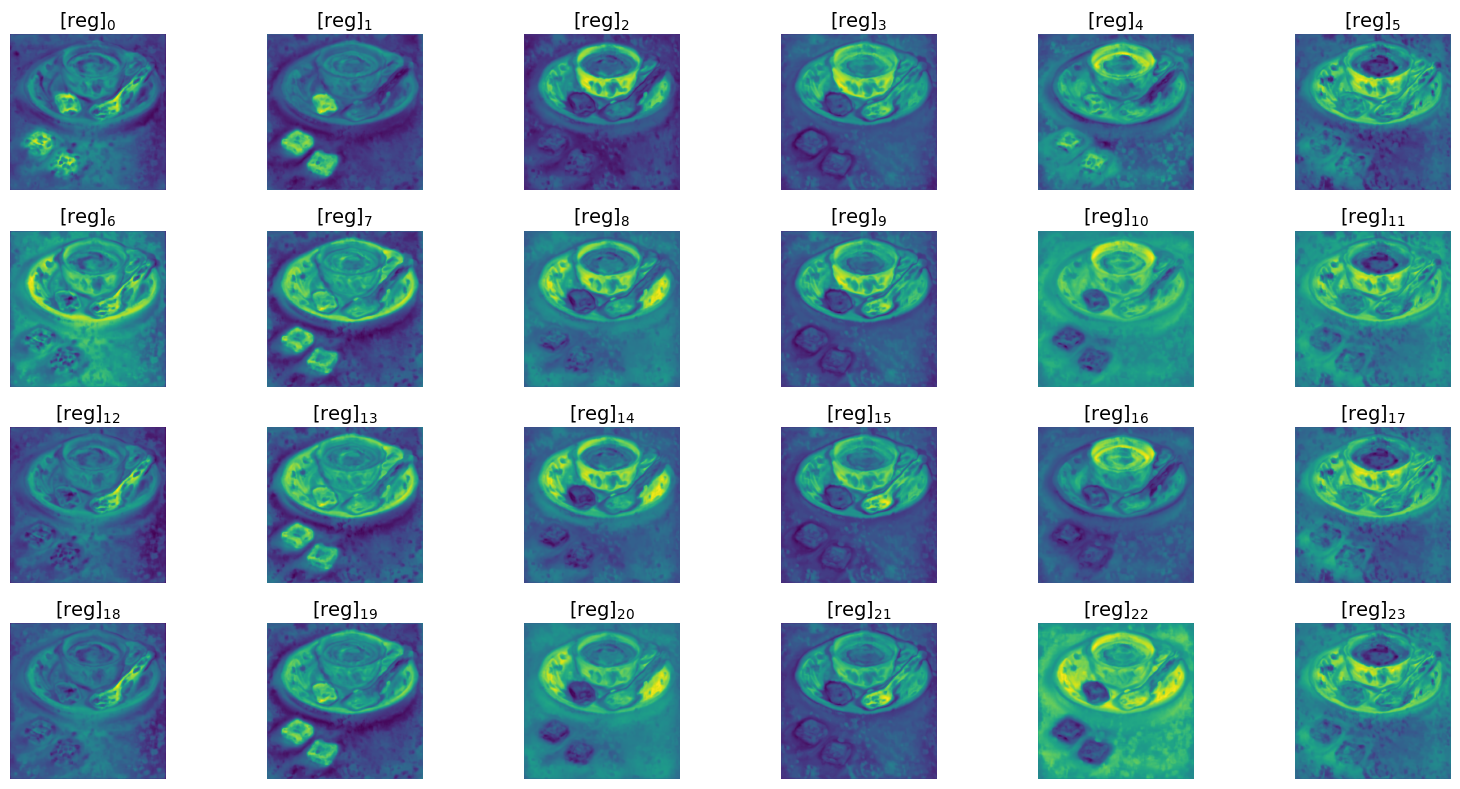

In [7]:
print(attn.shape)
fig, axs = plt.subplots(nrows=4, ncols=6)
fig.set_size_inches(16, 8)

for i in range(24):
    reg_i = attn[i, :, :]
    ax = axs[i // 6, i % 6]
    ax.imshow(reg_i)
    ax.set_axis_off()
    title = "$[\\text{reg}]_{"+str(i)+"}$"
    ax.set_title(title, fontsize=14)
plt.tight_layout()

(24, 490, 490)
uint8 255


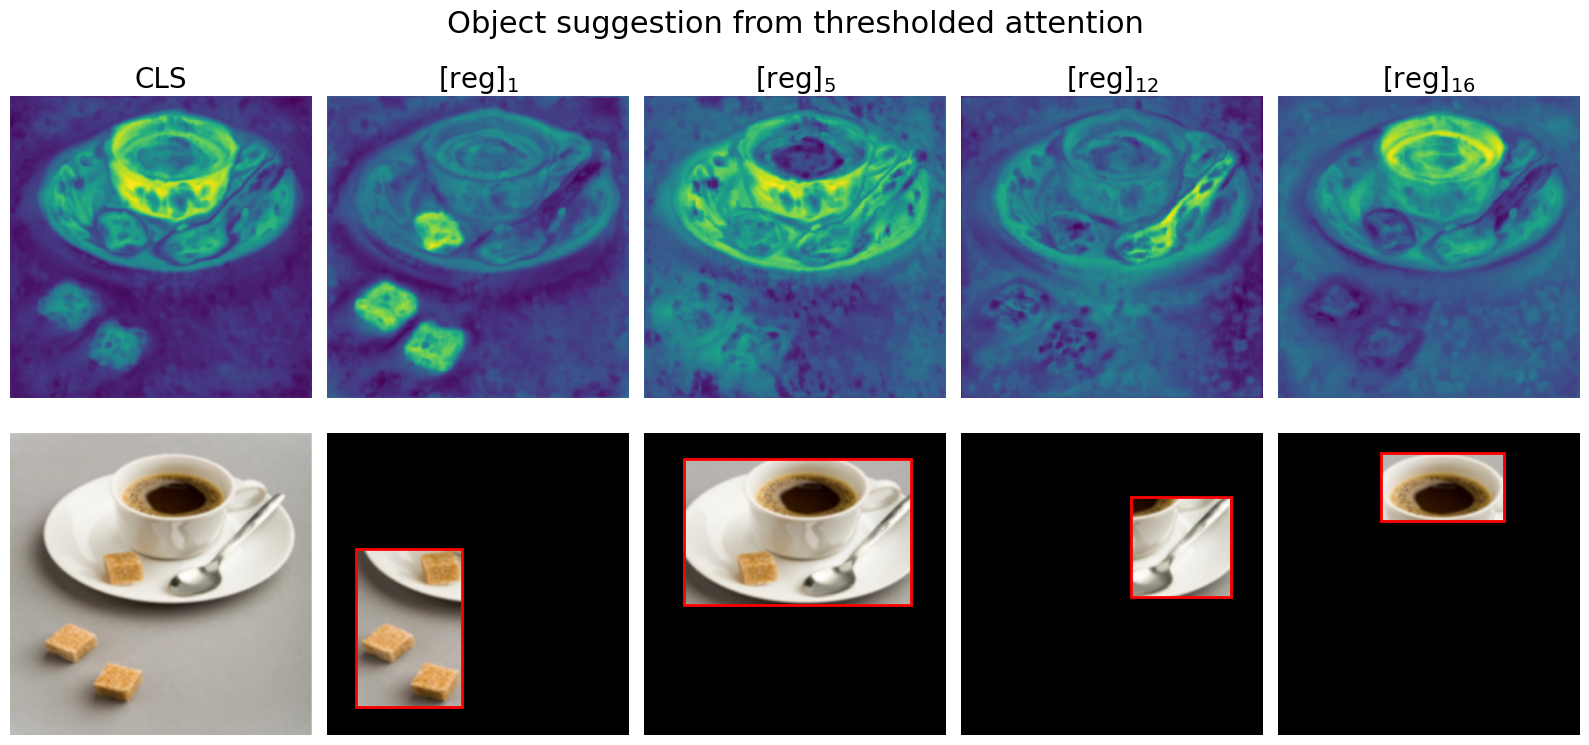

In [8]:
import matplotlib.patches as patches
print(attn.shape)
fig, axs = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(16, 8)

h, w = attn.shape[1:]
img_arr = np.array(img)
print(img_arr.dtype, np.amax(img_arr))

fig.suptitle("Object suggestion from thresholded attention", fontsize=22)
axs[0, 0].imshow(np.sum(cls_attn, axis=0))
axs[1, 0].imshow(img)

axs[0, 0].set_axis_off()
axs[1, 0].set_axis_off()
title = "CLS"
axs[0, 0].set_title(title, fontsize=20)

for j, i in enumerate([1, 5, 12, 16]):
    reg_i = attn[i, :, :]
    #threshold = threshold_multiotsu(reg_i, 2)
    ax_1 = axs[0, j + 1]
    ax_2 = axs[1, j + 1]
    #ax.imshow(reg_i > threshold[0])
    flat = reg_i.flatten().astype(np.float64)
    
    filtered = reg_i > 0.7 * np.amax(flat)
    idxs = np.nonzero(filtered)
    min_y, max_y = np.amin(idxs[0]), np.amax(idxs[0])
    min_x, max_x = np.amin(idxs[1]), np.amax(idxs[1])
    
    rect = patches.Rectangle((min_x, min_y), max_x - min_x,  max_y - min_y,linewidth=2, edgecolor='r', facecolor='none' )
    
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    mask[min_y:max_y, min_x:max_x, :] = 1
    ax_1.imshow(reg_i)
    ax_2.imshow(img_arr * mask)
    ax_2.add_patch(rect)

    ax_1.set_axis_off()
    ax_2.set_axis_off()
    title = "$[\\text{reg}]_{"+str(i)+"}$"
    ax_1.set_title(title, fontsize=20)
plt.tight_layout()